# Solar sail (maximum orbit change)

Maximize the dispacement of the solar sail in the tangent manifold of its orbital elements over one orbit:

$$ \delta I = \mathbf{G} \, u, $$
$$ \delta I = \varepsilon \int_{M_0}^{M_f} \mathbf{G}(I,M) \, u \ \textrm{d} M, \quad u \in \mathcal{U}$$
$$ \delta I (M_0) = 0, \quad \delta I (M_f) \parallel \mathbf{b}, $$
$$ \left( \delta I (M_f) \, | \, \mathbf{b} \right) \longrightarrow \max, $$
$$ M_0 = 0; M_f = 2 \pi $$

Fixed initial Keplerian orbit and direction of the displacement $\mathbf{b}$. 

[Thumbnail](figs/kepler-py.png)

## Initializations

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
from mpl_toolkits.mplot3d import Axes3D
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp
from scipy.linalg import null_space
from gve import *
from os import system

# Definition of optical parameters 
rho     = 0.6         # Specular reflection coefficient
a       = 1. - rho    # Absorption coefficient
s       = 0.94        # Diffuse reflection coefficient 
eps_f   = 0.05        # Emissivity front coeff 0.05
eps_b   = 0.55        # Emissivity back coeff 0.55
Bf      = 0.79        # Front Lambertian coeff 0.79
Bb      = 0.55        # Back Lambertian coeff 0.55
eps     = (Bf * eps_f - Bb * eps_b) / (eps_b + eps_f) 
#opt_p   = np.array([rho, s, eps_f, eps_b, Bf, Bb, eps])
b       = np.array([1. - rho * s, 2. * rho * s, Bf * rho * (1. - s) + (1. - rho) * eps ])

# Parameters of the problem
cont    = 1.          # 0 for triangular cone, 1 for real drop 
mu      = 1.

# Initial guess of pI taken from Matlab Convex Programming
pI         = np.array([0.1643,   -2.1154,    1.0000,   -0.7211,    2.6793])
M1_guess   = 0.8762
M2_guess   = 5.3791
I1_guess   = np.array([-0.5601,    0.1033,    1.0363,    0.4925,    0.0941])
I2_guess   = np.array([-0.5543,    0.1083,    1.0470,    0.4935,    0.0936])
z          = np.hstack((pI, M1_guess, M2_guess, I1_guess, I2_guess))
sDir       = np.array([0., 0., -1.])
   

def deg2rad(x):
    y = x * np.pi / 180.
    return y

def rad2deg(x):
    y = x * 180. / np.pi
    return y


# Initial state

I       = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.6])                         # Initial state
d       = np.array([ 0.,  0.,  1.,  0.,  0.])                                               # Direction of the displacement
I0      = np.array([0., 0., 0., 0., 0])                                                     # delta I (0)
M0      = 0
Mf      = 2*np.pi

# Real cone force definition
cBeta   = (- b[0] * b[2]  - 2. * b[1] * b[2] + \
             np.sqrt(b[0] ** 2 * b[2] ** 2 - 4. * b[0] * b[2] ** 2 * b[1] + 8. * b[0] ** 2 * b[1] ** 2 + 4. * b[1] ** 3 * b[0])) / \
             (4. * b[0] * b[1] + 2. * b[1] ** 2);
sBeta 	= np.sqrt(1 - cBeta ** 2);
fs    	= b[0] * cBeta + (b[1] * cBeta ** 2 + b[2] * cBeta) * cBeta;
fperp 	= (b[1] * cBeta ** 2 + b[2] * cBeta) * sBeta;
fCone 	= np.array([fs, fperp])


pars    = np.hstack((mu, I, fCone, b))

# Orthogonal vector family
d_orth  = scipy.linalg.null_space([d])                                                                     # Orthogonal space of b
d_orth  = d_orth.transpose()

In [2]:
#!pygmentize hfun.f90			

## Hamiltonian

In [3]:
!python -m numpy.f2py -c hfun.f90     hfun.pyf     -m hfun     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90   hfun_d.pyf   -m hfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90 hfun_d_d.pyf -m hfun_d_d > /dev/null 2>&1

In [4]:
from hfun     import hfun     
from hfun_d   import hfun_d   
from hfun_d_d import hfun_d_d 

hfun_u   = lambda M, q, p, cont                   : hfun.hfun_u(M, q, p, pars, cont)
ufun     = lambda M, q, p, cont                   : hfun.control(M, q, p, pars, cont) 
dhfun_u  = lambda M, q, dq, p, dp, cont           : hfun_d.hfun_u_d(M, q, dq, p, dp, pars, cont)
d2hfun_u = lambda M, q, dq, d2q, p, dp, d2p, cont : hfun_d_d.hfun_u_d_d(M, q, dq, d2q, p, dp, d2p, pars, cont)

In [5]:
def dhfun_0(M, q, dq, p, dp, cont):
    h = 0.0
    dh  = 0.0
    return h, dh

def d2hfun_0(M, q, dq, d2q, p, dp, d2p, cont):
    h   = 0.0
    dh  = 0.0
    d2h = 0.0
    return h, dh, d2h

def hfun_0(M, q, p, cont):
    h = 0.0
    return h

In [6]:
hfun_u      = tools.tensorize(dhfun_u, d2hfun_u, tvars=(2, 3), full=True)(hfun_u)
hfun_0      = tools.tensorize(dhfun_0, d2hfun_0, tvars=(2, 3), full=True)(hfun_0)
ufun        = tools.vectorize(vvars=(1,2,3))(ufun)
Hu          = ocp.Hamiltonian(hfun_u)
H0          = ocp.Hamiltonian(hfun_0)
fu          = ocp.Flow(Hu)
f0          = ocp.Flow(H0)

## Shooting function

In [7]:
def dshoot(z, dz, pars, d, d_orth, cont, next=False):
    I0  = np.zeros(5)
    M0  = 0.
    Mf  = 2. * np.pi

    pI  = z[0 : 5]
    M1  = z[5]
    M2  = z[6]
    I1  = z[7 : 12]
    I2  = z[12 : 17]

    dpI = dz[0 : 5]
    dM1 = dz[5]
    dM2 = dz[6]
    dI1 = dz[7 : 12]
    dI2 = dz[12 : 17]

    #----------------------------------
    (I1sol, dI1sol), (pI1, dpI1) = fu(M0, I0, (pI, dpI), (M1, dM1), cont)
    (I2sol, dI2sol), (pI2, dpI2) = f0((M1, dM1), (I1, dI1), (pI, dpI), (M2, dM2), cont)
    (If, dIf), (pIf, dpIf)       = fu((M2, dM2), (I2, dI2), (pI, dpI), Mf, cont)

    #----------------------------------
    s           = np.zeros(17)
    s[0]        = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5]    = np.dot(d_orth, If)

    s[7 : 12]   = I1 - I1sol 
    s[12 : 17]  = I2 - I2sol

    ds          = np.zeros(17)
    ds[0]       = dpIf[0] * d[0] + dpIf[1] * d[1] + dpIf[2] * d[2] + dpIf[3] * d[3] + dpIf[4] * d[4] 
    ds[1 : 5]   = np.dot(d_orth, dIf)

    ds[7 : 12]  = dI1 - dI1sol
    ds[12 : 17] = dI2 - dI2sol

    s[5], ds[5] = Hu((M1, dM1), (I1, dI1), (pI, dpI), cont) #- H0((M1, dM1), (I1, dI1), (pI, dpI), pars, cont)
    s[6], ds[6] = Hu((M2, dM2), (I2, dI2), (pI, dpI), cont) #- H0((M2, dM2), (I2, dI2), (pI, dpI), pars, cont)

    # on impose pas la continuité de pI car il est constant
    # il faut imposer la continuité de l'etat deltaI entre les switchs entre 7 et 17 

    if not next: return s, ds
    else: return s, ds, (Mf, If, pIf, None)

#@tools.vectorize(vvars=(3,))
#@tools.vectorize(vvars=(4,), next=True)
@tools.tensorize(dshoot, tvars=(1,), full=True)
def shoot(z, pars, d, d_orth, cont, next=False):
    I0 = np.zeros(5)
    M0 = 0.
    Mf = 2. * np.pi 
    pI = z[0 : 5]
    M1 = z[5]
    M2 = z[6]
    I1 = z[7 : 12]
    I2 = z[12 : 17]

    #----------------------------------
    I1sol, pI1 = fu(M0, I0, pI, M1, cont)
    I2sol, pI2 = f0(M1, I1, pI, M2, cont)
    If, pIf    = fu(M2, I2, pI, Mf, cont)

    #----------------------------------
    s        = np.zeros(17)
    s[0]     = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5] = np.dot(d_orth, If)

    # theta1            = atan2(pI1*sPerp/(pI1*sDir))
    # theta2            = atan2(pI2*sPerp/(pI2*sDir))
    # s[5]                      = theta1 - cone_alpha - deg2rad(90.)
    # s[6]                      = theta2 - cone_alpha - deg2rad(90.)

    s[5]        = Hu(M1, I1, pI, cont)
    s[6]        = Hu(M2, I2, pI, cont)
    s[7 : 12]   = I1 - I1sol 
    s[12 : 17]  = I2 - I2sol

    # on impose pas la continuité de pI car il est constant
    # il faut imposer la continuité de l'etat deltaI entre les switchs

    if not next: return s
    else: return s, (Mf, If, pIf, None)

In [47]:
# function that calculates the number of switches

def switch_fun(z, pars, f):
    #rho = opt_p[0]; s = opt_p[1]; eps_f = opt_p[2]; eps_b = opt_p[3]; Bf = opt_p[4]; Bb = opt_p[5]; eps = opt_p[6]
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]
    
    # astrodynamical parameters
    b      = a * np.sqrt(1 - e**2) 
    n      = np.sqrt(mu/a**3) 
    h      = n * a * b
    p      = b ** 2 / a
    c      = 0.1
    c1     = p / h / e
    c2     = p / h
    c3     = 2 * a ** 2 / h
    k1     = pI[2] * c1
    k2     = pI[3] * e * c3
    k3     = pI[4] * c2
    k4     = pI[3] * c3
    k5     = pI[0] * c2 * np.sin(w) / np.sin(i)
    k6     = pI[0] * c2 * np.cos(w) / np.sin(i)
    k7     = pI[1] * c2 * np.cos(w)
    k8     = pI[1] * c2 * np.sin(w)
    k9     = pI[2] * c2 * np.cos(w) / np.sin(w)
    d1     = 4*k1*k4 + 4*e*k1*k3 + 2*k9*c**2*(k6-k8)
    d2     = 2*(k2+k3)*k4 + 2*e*k1**2 + 2*e*(k2+k3)**2 + 2*e*k4**2 + 2*e*k3**2 + 2*e*k3*(k2+k3) + \
                2*k3*k4 + 2*e**2*k3*k4 + 2*k9*c**2*(k5+k7)
    d3     = k1**2*e**2 + (k2+k3)**2*e**2 + k4**2*e**2 + 4*e*(k2+k3)*k4 + k3**2 + 2*k3*(k2+k3) + \
                2*e**2*k3*(k2+k3) + 2*e*k3*k4 - c**2*(k5+k7)**2
    d4     = 3*k1**2 - c**2 * (k6-k8)
    d5     = 6*e*k1*k4 + 4*k1*k3 + 2*e**2*k1*k3 + 2*k1*(k2+k3) -2*c**2*(k5+k7)*(k6-k8)
    d6     = 2*e**2*k1*k4 + 2*k1*k3 + 2*e*k1*(k2+k3)
    d7     = 2*e*k1**2
    d8     = 2*e**2*k4*(k2+k3) + 2*e*k3*(k2+k3)
    d9     = k1**2 + (k2+k3)**2 + k4**2 + e**2*k3**2 + 2*e*k3*k4 - c**2*k9**2
    sol    = d1*np.sin(f) + d2*np.cos(f) + d3*np.cos(f)**2 + d4*np.sin(f)**2 + d5*np.sin(f)*np.cos(f) + \
                d6*np.sin(f)*np.cos(f)**2 + d7*np.sin(f)**2*np.cos(f) + d8*np.cos(f)**3 + d9
    
    return sol

switch_f   = lambda f                 : switch_fun(z, pars, f)

print(switch_fun(z, pars, np.linspace(0, 2*np.pi, 1000)))
x = scipy.optimize.broyden1(switch_f, np.linspace(0, 2*np.pi, 10), f_tol=1e-14)
print(x)
print(np.linspace(0, 2*np.pi, 10))
    
    
def shoot_auto(z, pars, d, d_orth, cont, next=False):
    I0 = np.zeros(5)
    M0 = 0.
    Mf = 2. * np.pi 
    pI = z[0 : 5]

    #----------------------------------
    #Calculer le nombre de switch 
    nb_switches = 0
    return 0

[ 9.51579641  9.58287269  9.65001464  9.71720533  9.7844278   9.85166504
  9.91890005  9.9861158  10.05329523 10.1204213  10.18747696 10.25444514
 10.32130881 10.38805093 10.45465448 10.52110245 10.58737788 10.65346383
 10.71934337 10.78499963 10.8504158  10.91557508 10.98046074 11.04505613
 11.10934462 11.17330968 11.23693482 11.30020365 11.36309986 11.4256072
 11.48770952 11.54939079 11.61063503 11.67142638 11.73174911 11.79158757
 11.85092622 11.90974967 11.96804262 12.02578991 12.08297652 12.13958755
 12.19560823 12.25102396 12.30582026 12.35998282 12.41349748 12.46635021
 12.51852719 12.57001472 12.6207993  12.67086758 12.72020639 12.76880277
 12.81664389 12.86371715 12.91001011 12.95551054 13.00020639 13.04408584
 13.08713723 13.12934913 13.17071032 13.21120977 13.25083668 13.28958047
 13.32743076 13.36437741 13.40041049 13.43552031 13.46969739 13.50293249
 13.53521662 13.56654099 13.59689709 13.62627661 13.65467151 13.68207398
 13.70847645 13.73387162 13.75825241 13.78161202 13.

NoConvergence: [ 3.79167919e+154  4.52788548e+154 -9.68497568e+154  1.04608285e+153
 -8.52928497e+154 -1.54610830e+155 -3.47668104e+154  7.04035046e+154
 -1.27877861e+154  1.82595926e+154]

In [41]:
@tools.vectorize(vvars =(1,))
def control(M, I, pI, cont):
    sol  = np.array([0., 0., 0.])
    if type(M)==int:
        if Hu(M, I, pI, cont) < 0.:
            sol = np.array([0., 0., 0.])
        else: 
            sol = ufun(M, I, pI, cont)
    else:
        for ii in range(len(M)):
            if Hu(M[ii], I, pI, cont) < 0.:
                sol = np.vstack((sol, np.array([0., 0., 0.])))
            else: 
                sol = np.vstack((sol, ufun(M, I, pI, cont)))   
        sol = np.delete(sol, 0, 0)
    return sol

## Solve

In [10]:
dfoo = lambda z, dz: shoot((z, dz), pars, d, d_orth, cont) 
foo = lambda z: shoot(z, pars, d, d_orth, cont)
foo = tools.tensorize(dfoo, full=True)(foo)

In [11]:
foo(z)

array([ 0.00000000e+00, -1.63070653e-01, -3.68036519e-01, -5.35988101e-01,
       -1.63407961e-01, -1.40443925e-03, -1.45727409e-02,  8.93744468e-01,
       -1.06483063e-01, -1.23174478e+00, -9.81858728e-02,  5.33064385e-02,
        5.80000000e-03,  5.00000000e-03,  1.07000000e-02,  1.00000000e-03,
       -5.00000000e-04])

In [12]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 
#et = time.time(); sol = nle.solve(foo, z, df=foo, options=nleopt); 
et = time.time(); sol = nle.solve(foo, z, options=nleopt); 


     Calls  |f(x)|                 |x|
 
         1  1.678157350909314e+00  6.798543214542362e+00
         2  2.960452974927052e-01  7.529225157916933e+00
         3  1.630824567613399e-01  7.587751163582967e+00
         4  1.150920286137783e-02  7.553182903421222e+00
         5  3.236031550484008e-03  7.551576843543941e+00
         6  8.789172039579649e-04  7.553353219868562e+00
         7  8.089127814421227e-05  7.553762104819763e+00
         8  3.639397027194399e-06  7.553730525779408e+00
         9  4.716889290660897e-07  7.553731475640311e+00
        10  7.187938419999149e-08  7.553731312381201e+00
        11  4.086224725006060e-09  7.553731289491504e+00
        12  1.485052020176088e-10  7.553731290564301e+00

 Results of the nle solver method:

 xsol    =  [ 0.42444195 -1.76919032  1.         -0.47318055  3.18013039  0.94528904
  5.16757906 -1.34497861  0.23782286  2.22037033  0.77498892  0.10425533
 -1.34497861  0.23782286  2.22037033  0.77498892  0.10425533]
 f(xsol) =  [ 0.0

In [13]:
z_sol = sol.x; et = time.time() - et
print('Elapsed time:', et)
print('z_sol =', z_sol)
print('foo =', foo(z_sol))

Elapsed time: 1.0200400352478027
z_sol = [ 0.42444195 -1.76919032  1.         -0.47318055  3.18013039  0.94528904
  5.16757906 -1.34497861  0.23782286  2.22037033  0.77498892  0.10425533
 -1.34497861  0.23782286  2.22037033  0.77498892  0.10425533]
foo = [ 0.00000000e+00  2.17877738e-11 -6.25046364e-11  2.92347709e-11
  1.83479635e-11 -1.86514137e-11  1.26626265e-10  4.10893541e-12
  2.62950772e-12 -6.21724894e-12 -5.73996406e-12 -1.85836069e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


In [14]:
pI         = z_sol[0 : 5]
M1         = z_sol[5]
M2         = z_sol[6]
I1         = z_sol[7 : 12]
I2         = z_sol[12 : 17]
u          = control(M0, I0, pI, cont)

## Function of continuous integration

In [15]:
def plotSolutionBSB(pI, M1, M2, Mf, sDir, cont, nOrb):

    N       = 20
    
    M_vect  = np.array([])
    g1      = np.array([])
    g2      = np.array([])
    g3      = np.array([])
    a       = np.array([])
    e       = np.array([])
    I       = np.array([0., 0., 0., 0., 0]) 
    I0      = np.array([0., 0., 0., 0., 0]) 
    M0      = 0
    M0_2_M1 = np.linspace(M0, M1, N+1)
    M1_2_M2 = np.linspace(M1, M2, N+1)
    M2_2_Mf = np.linspace(M2, Mf, N+1)
    u_vect  = np.array([0., 0., 0.])
        
    for ii in range(nOrb):
        Mspan1  = list((ii)*2*np.pi*np.ones(N+1)+M0_2_M1)
        Mspan2  = list((ii)*2*np.pi*np.ones(N+1)+M1_2_M2)
        Mspanf  = list((ii)*2*np.pi*np.ones(N+1)+M2_2_Mf)
        
        I1sol, pI1sol = fu(M0, I0, pI, Mspan1, cont)  # on [ 0, t1]
        I2sol, pI2sol = f0(Mspan1[-1], I1sol[-1], pI, Mspan2, cont)  # on [t1, t2]
        Ifsol, pIfsol = fu(Mspan2[-1], I2sol[-1], pI, Mspanf, cont)  # on [t2, tf]
        
        M_vect        = np.hstack((M_vect, Mspan1, Mspan2, Mspanf))  
        
        for kk in range(N+1):
            val           = I1sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        for kk in range(N+1):
            val           = I2sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        for kk in range(N+1):
            val           = Ifsol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        I0            = Ifsol[-1]
        M0            = Mspanf[-1]
    
    u_vect = control(M_vect, I, pI, cont)
    u_s    = np.dot(u_vect,sDir)
    u_1    = u_vect[:,0]
    u_2    = u_vect[:,1]
    u_3    = u_vect[:,2]

    ang1   = np.arccos(u_s/np.linalg.norm(u_vect,axis=1))
    where_are_NaNs = np.isnan(ang1)
    ang1[where_are_NaNs] = 0
    ang1   = rad2deg(ang1)
    
    #ang2   = np.sqrt(np.divide(u_3 ** 2, u_2 ** 2))
    #where_are_NaNs = np.isnan(ang2)
    #ang2[where_are_NaNs] = 0
    ang2   = np.arctan2(u_3 ** 2, u_2 ** 2)
    ang2   = rad2deg(ang2)

    M_vect = M_vect/(2*np.pi)
    fig = plt.figure(); plt.tight_layout()
    ax1  = fig.add_subplot(421); 
    ax1.plot(M_vect, g1); 
    ax2  = fig.add_subplot(422); 
    ax2.plot(M_vect, g2); 
    ax3  = fig.add_subplot(423); 
    ax3.plot(M_vect, g3); 
    ax4  = fig.add_subplot(424); 
    ax4.plot(M_vect, a); 
    ax5  = fig.add_subplot(425); 
    ax5.plot(M_vect, e); 
    #ax6  = fig.add_subplot(426); 
    #ax6.plot(M_vect, u_s); 
    ax7  = fig.add_subplot(427); 
    ax7.plot(M_vect, ang1); 
    ax8  = fig.add_subplot(428); 
    ax8.plot(M_vect, ang2); 

    
    ax1.set_xlabel('$Orbit \, number$'); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
    ax2.set_xlabel('$Orbit \, number$'); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
    ax3.set_xlabel('$Orbit \, number$'); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
    ax4.set_xlabel('$Orbit \, number$'); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
    ax5.set_xlabel('$Orbit \, number$'); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
    #ax6.set_xlabel('$Orbit \, number$'); ax6.set_ylabel('$u_s$');      ax6.axhline(0, color='k')
    ax7.set_xlabel('$Orbit \, number$'); ax7.set_ylabel('$Cone \ ang1$');      ax7.axhline(0, color='k')
    ax8.set_xlabel('$Orbit \, number$'); ax8.set_ylabel('$Cone \ ang2$');      ax8.axhline(0, color='k')
    #ax9.set_xlabel('$Orbit \, number$'); ax9.set_ylabel('$u_4$');      ax9.axhline(0, color='k')


## Plots

In [16]:
pI         = z_sol[0 : 5]
M1         = z_sol[5]
M2         = z_sol[6]
I1         = z_sol[7 : 12]
I2         = z_sol[12 : 17]

If, pI = fu(M2, I2, pI, 2*np.pi, cont)

/Users/aherasim/anaconda3/envs/ct/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


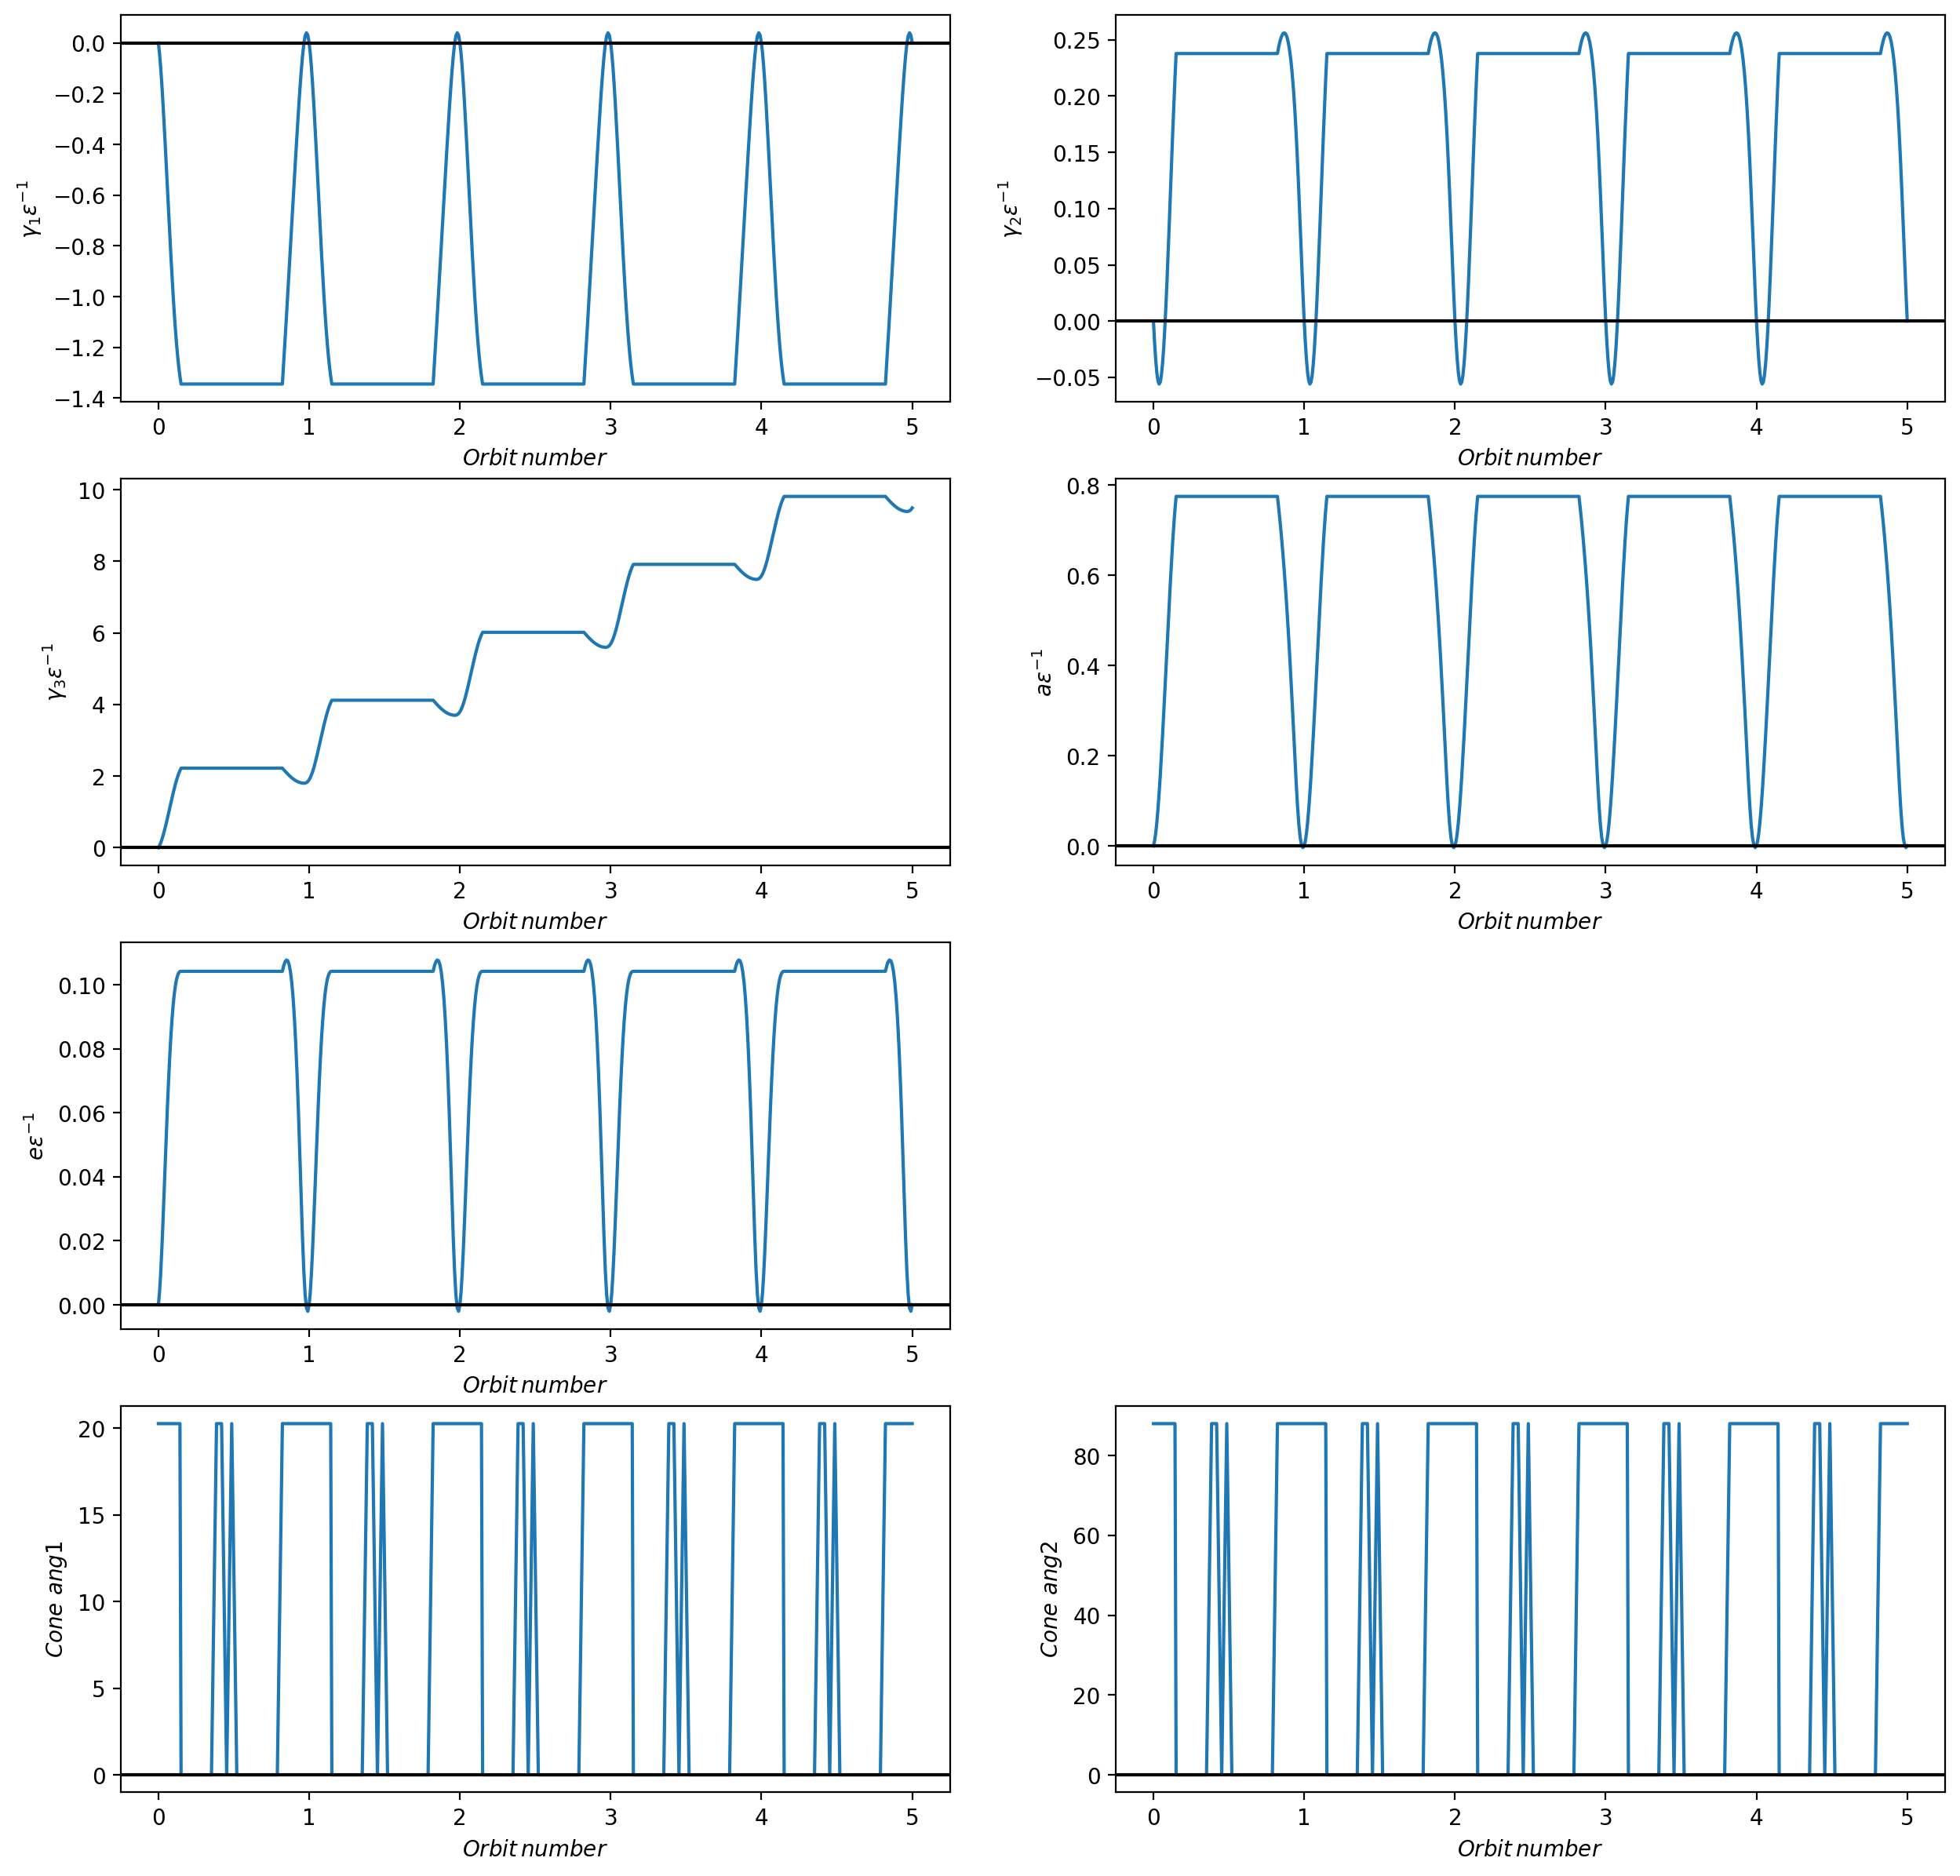

In [17]:
plotSolutionBSB(pI, M1, M2, Mf, sDir, cont, 5)